In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

# Configure matplotlib for Jupyter notebook inline display
%matplotlib inline

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.titlesize': 18,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}',
    'figure.figsize': [12, 8],  # Default figure size for notebook
    'figure.dpi': 100,  # Display DPI for notebook
    'savefig.dpi': 300,  # High DPI for saved files
    'savefig.bbox': 'tight',
    'savefig.transparent': False
})


# Export as PNG and PGF with error handling
def safe_save_figure(fig, base_name, formats=['png', 'pgf']):
    """Safely save figure with error handling and timestamp fallback"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    saved_files = []

    for fmt in formats:
        filename = f"{base_name}.{fmt}"
        backup_filename = f"{base_name}_{timestamp}.{fmt}"

        try:
            if fmt == 'png':
                fig.savefig(filename, dpi=300, bbox_inches='tight', format=fmt)
            elif fmt == 'pgf':
                fig.savefig(filename, bbox_inches='tight', format=fmt)
            else:
                fig.savefig(filename, bbox_inches='tight', format=fmt)
            saved_files.append(filename)
            print(f"✓ Saved: {filename}")
        except PermissionError:
            try:
                # Try with timestamp
                if fmt == 'png':
                    fig.savefig(backup_filename, dpi=300, bbox_inches='tight', format=fmt)
                elif fmt == 'pgf':
                    fig.savefig(backup_filename, bbox_inches='tight', format=fmt)
                else:
                    fig.savefig(backup_filename, bbox_inches='tight', format=fmt)
                saved_files.append(backup_filename)
                print(f"⚠ File was locked, saved as: {backup_filename}")
            except Exception as e:
                print(f"✗ Failed to save {fmt} format: {str(e)}")
        except Exception as e:
            print(f"✗ Failed to save {filename}: {str(e)}")

    return saved_files

Calculating base case...
Base case - Time: 12.333s, Energy: 711.363J
Testing phi = 0.8
Ratio range: 0.010 to 100.0
Base speed range: 1.0 to 50.0 Mb/s
Grid size: 50 x 50 = 2500 points
Computing cost grid...
Processing base speed 1/50: 1.0 Mb/s
Processing base speed 11/50: 11.0 Mb/s
Processing base speed 21/50: 21.0 Mb/s
Processing base speed 31/50: 31.0 Mb/s
Processing base speed 41/50: 41.0 Mb/s
Grid computation complete!
Dataset 1 (both costs < base): 1964 points
Dataset 2 (time < base, energy > base): 0 points
Dataset 3 (time > base, energy < base): 139 points
Other points: 397 points
Creating zones plot...
✓ Saved: cost_analysis_zones.png
✓ Saved: cost_analysis_zones.pgf
Zones plot exported as: cost_analysis_zones.png, cost_analysis_zones.pgf


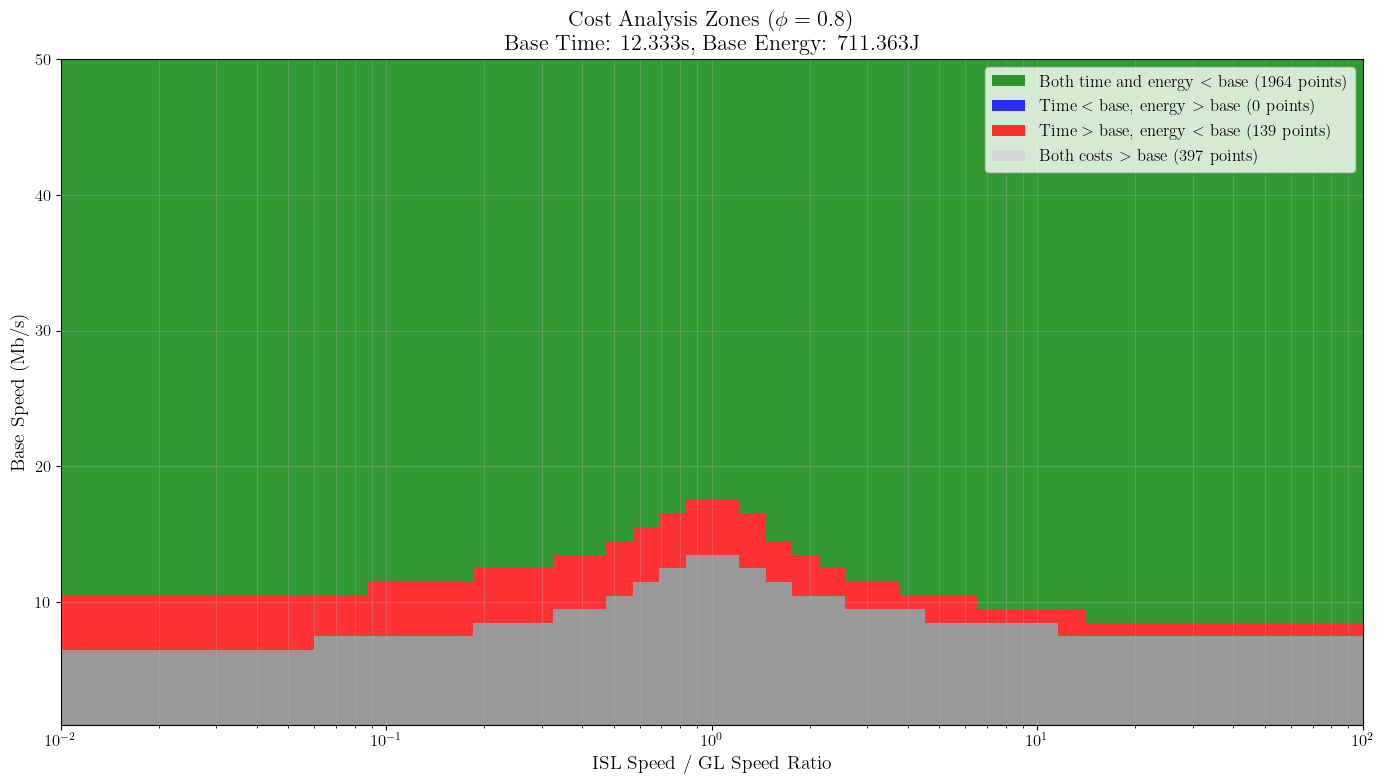

Creating contour plots...
✓ Saved: subanalysis.png
✓ Saved: subanalysis.pgf
Subanalysis plot exported as: subanalysis.png, subanalysis.pgf


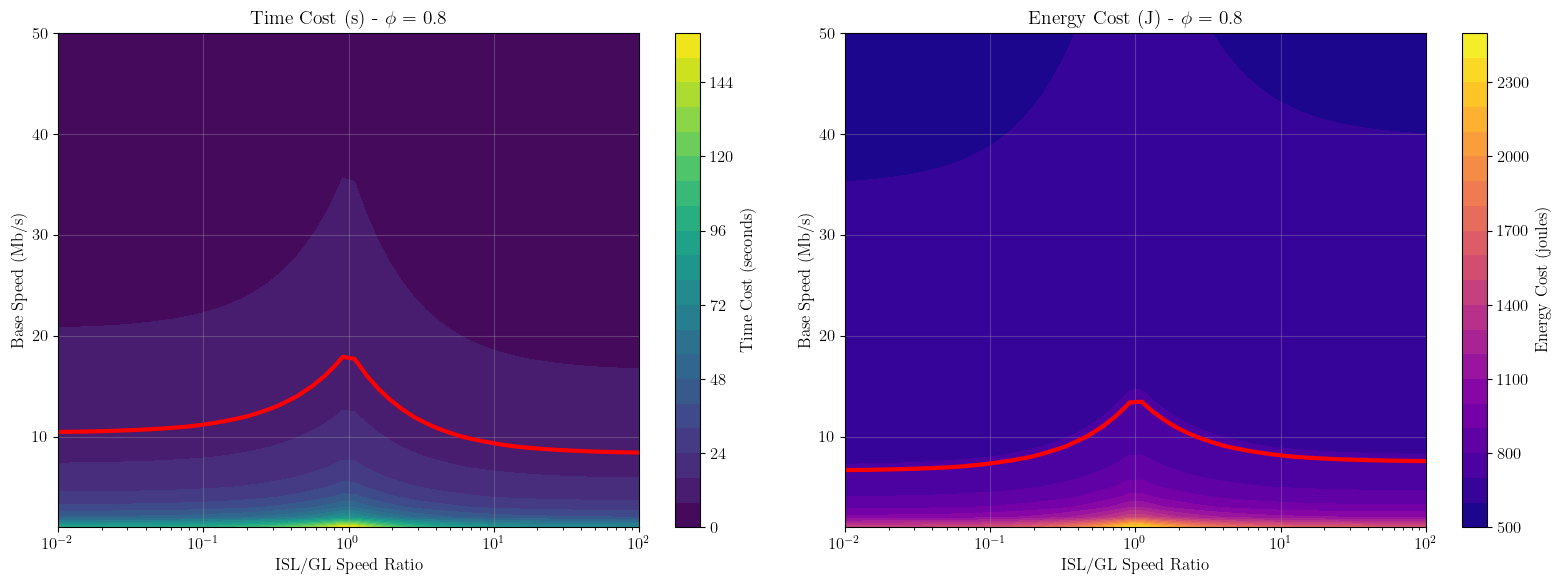

In [10]:
# Parameters
data_size = 100
phi = 0.8  # Default phi value
max_base_speed = 50.0  # Maximum base speed to test

# Base Case - calculate reference costs
print("Calculating base case...")
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(speed=30.0, phi=0.9)
base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(data_size, energy_memory=5, energy_computing=25)
d_out = obc.process(data_size)

ground_link = TransmissionNode(speed=10.0)
base_time_cost += ground_link.time_cost(d_out)
base_energy_cost += ground_link.energy_cost(d_out, energy=5, distance=700)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")

# Create parameter grids
# x-axis: ISL/GL speed ratios (logarithmic)
ratio_exponents = np.linspace(-2, 2, 50)  # From 10^-2 to 10^2
ratios = 10 ** ratio_exponents

# y-axis: base speeds (linear)
base_speeds = np.linspace(1, max_base_speed, 50)

# Create meshgrid for plotting
ratio_mesh, base_speed_mesh = np.meshgrid(ratios, base_speeds)

print(f"Testing phi = {phi}")
print(f"Ratio range: {ratios[0]:.3f} to {ratios[-1]:.1f}")
print(f"Base speed range: {base_speeds[0]:.1f} to {base_speeds[-1]:.1f} Mb/s")
print(f"Grid size: {len(base_speeds)} x {len(ratios)} = {len(base_speeds) * len(ratios)} points")

# Initialize arrays to store results
time_costs = np.zeros_like(ratio_mesh)
energy_costs = np.zeros_like(ratio_mesh)

# Calculate user costs once (independent of ISL/GL speeds)
obc = ComputingNode(speed=30.0, phi=0.9)
user_time_cost = obc.time_cost(data_size)
user_energy_cost = obc.energy_cost(data_size, energy_memory=1, energy_computing=5)
d_out_obc = obc.process(data_size)

print("Computing cost grid...")
for i, base_speed in enumerate(base_speeds):
    if i % 10 == 0:
        print(f"Processing base speed {i + 1}/{len(base_speeds)}: {base_speed:.1f} Mb/s")

    for j, ratio in enumerate(ratios):
        # Calculate ISL and GL speeds based on ratio and base speed
        if ratio >= 1:
            # ISL dominates: fix GL speed, vary ISL speed
            speed_gl = base_speed
            speed_isl = ratio * base_speed
        else:
            # GL dominates: fix ISL speed, vary GL speed
            speed_isl = base_speed
            speed_gl = base_speed / ratio

        # ISL transmission
        isl = TransmissionNode(speed=float(speed_isl))
        iteration_time_cost = isl.time_cost(d_out_obc)
        iteration_energy_cost = isl.energy_cost(d_out_obc, energy=5, distance=100)

        # Edge computing with specified phi value
        edge_computer = ComputingNode(speed=300.0, phi=phi)
        iteration_time_cost += edge_computer.time_cost(d_out_obc)
        iteration_energy_cost += edge_computer.energy_cost(d_out_obc, energy_memory=5, energy_computing=25)
        d_out_ec = edge_computer.process(d_out_obc)

        # Ground link transmission
        ground_link = TransmissionNode(speed=float(speed_gl))
        iteration_time_cost += ground_link.time_cost(d_out_ec)
        iteration_energy_cost += ground_link.energy_cost(d_out_ec, energy=5, distance=700)

        # Total costs
        time_costs[i, j] = user_time_cost + iteration_time_cost
        energy_costs[i, j] = user_energy_cost + iteration_energy_cost

print("Grid computation complete!")

# Classify points based on cost comparisons with base case
condition_1 = (time_costs < base_time_cost) & (energy_costs < base_energy_cost)  # Both better
condition_2 = (time_costs < base_time_cost) & (energy_costs > base_energy_cost)  # Time better, energy worse
condition_3 = (time_costs > base_time_cost) & (energy_costs < base_energy_cost)  # Time worse, energy better

print(f"Dataset 1 (both costs < base): {np.sum(condition_1)} points")
print(f"Dataset 2 (time < base, energy > base): {np.sum(condition_2)} points")
print(f"Dataset 3 (time > base, energy < base): {np.sum(condition_3)} points")
print(f"Other points: {np.sum(~(condition_1 | condition_2 | condition_3))} points")

# FIRST PLOT: Create zones plot with logarithmic x-axis
print("Creating zones plot...")

# Create new figure
fig, ax = plt.subplots(figsize=(14, 8))

# Create a classification matrix for zones
# 0 = other/worse, 1 = both better (green), 2 = time better/energy worse (blue), 3 = energy better/time worse (red)
zone_matrix = np.zeros_like(ratio_mesh)
zone_matrix[condition_1] = 1  # Both costs < base (green)
zone_matrix[condition_2] = 2  # Time < base, energy > base (blue)
zone_matrix[condition_3] = 3  # Time > base, energy < base (red)

colors = ['gray', 'green', 'blue', 'red']  # 0=gray, 1=green, 2=blue, 3=red
custom_cmap = ListedColormap(colors)

# Use pcolormesh with logarithmic x-axis for proper scaling
mesh = ax.pcolormesh(ratio_mesh, base_speed_mesh, zone_matrix,
                     cmap=custom_cmap,
                     vmin=0, vmax=3,
                     alpha=0.8,
                     shading='auto')

# Set logarithmic scale for x-axis
ax.set_xscale('log')

# Labels and title with LaTeX formatting
ax.set_xlabel(r'ISL Speed / GL Speed Ratio', fontsize=14)
ax.set_ylabel(r'Base Speed (Mb/s)', fontsize=14)
ax.set_title(r'Cost Analysis Zones ($\phi = {}$)'.format(phi) + '\n' +
             r'Base Time: {:.3f}s, Base Energy: {:.3f}J'.format(base_time_cost, base_energy_cost),
             fontsize=16)

# Set axis limits
ax.set_xlim(ratios[0], ratios[-1])
ax.set_ylim(base_speeds[0], base_speeds[-1])

# Create custom legend
legend_elements = [
    Patch(facecolor='green', alpha=0.8, label='Both time and energy $<$ base ({} points)'.format(np.sum(condition_1))),
    Patch(facecolor='blue', alpha=0.8, label='Time $<$ base, energy $>$ base ({} points)'.format(np.sum(condition_2))),
    Patch(facecolor='red', alpha=0.8, label='Time $>$ base, energy $<$ base ({} points)'.format(np.sum(condition_3))),
    Patch(facecolor='lightgray', alpha=0.8,
          label='Both costs $>$ base ({} points)'.format(np.sum(~(condition_1 | condition_2 | condition_3))))
]
ax.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Add grid for better readability
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()

# Export using safe save function
saved_files = safe_save_figure(fig, 'cost_analysis_zones')
print("Zones plot exported as:", ', '.join(saved_files))

# Display in notebook
plt.show()

# SECOND PLOT: Create contour plots showing actual cost values
print("Creating contour plots...")

# Create new figure for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Time cost contour
contour1 = ax1.contourf(ratio_mesh, base_speed_mesh, time_costs, levels=20, cmap='viridis')
contour_lines1 = ax1.contour(ratio_mesh, base_speed_mesh, time_costs, levels=[base_time_cost], colors='red',
                             linewidths=3)

ax1.set_xscale('log')
ax1.set_xlabel('ISL/GL Speed Ratio', fontsize=12)
ax1.set_ylabel('Base Speed (Mb/s)', fontsize=12)
ax1.set_title(f'Time Cost (s) - $\\phi$ = {phi}', fontsize=14)
cbar1 = plt.colorbar(contour1, ax=ax1)
cbar1.set_label('Time Cost (seconds)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Energy cost contour
contour2 = ax2.contourf(ratio_mesh, base_speed_mesh, energy_costs, levels=20, cmap='plasma')
contour_lines2 = ax2.contour(ratio_mesh, base_speed_mesh, energy_costs, levels=[base_energy_cost], colors='red',
                             linewidths=3)

ax2.set_xscale('log')
ax2.set_xlabel('ISL/GL Speed Ratio', fontsize=12)
ax2.set_ylabel('Base Speed (Mb/s)', fontsize=12)
ax2.set_title(f'Energy Cost (J) - $\\phi$ = {phi}', fontsize=14)
cbar2 = plt.colorbar(contour2, ax=ax2)
cbar2.set_label('Energy Cost (joules)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Export using safe save function
saved_files = safe_save_figure(fig, 'subanalysis')
print("Subanalysis plot exported as:", ', '.join(saved_files))

# Display in notebook
plt.show()